###### Source from  "hands-on machine-learning with scikit-learn andTensorflow, O'reilly"

In [77]:
import numpy as np
import os
import tensorflow as tf

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
if os.path.isdir('./tf_logs'):
    print('already exist "tf_logs" folder')
else:    
    os.mkdir('./tf_logs')
    print('successfully create "tf_logs" folder')
    
if os.path.isdir('./tf_ckpt'):
    print('already exist "tf_ckpt" folder')
else:
    os.mkdir('./tf_ckpt')
    print('successfully create "tf_ckpt" folder')

already exist "tf_logs" folder
already exist "tf_ckpt" folder


# Basic RNNs

## using static_rnn()

###### static_rnn() vs dynamic_rnn()


- static_rnn()
: if you call tf.contrib.rnn.static_rnn with inputs having 200 time steps you are creating a static graph with 200 RNN steps. You are unable to pass in longer sequences than you've originally specified



- dyanmic_rnn()
: tf.nn.dynamic_rnn solves it. It uses a tf.While loop to dynamically construct the graph when it is executed. That means graph creation is faster and you can feed batches of variable size.

In [2]:
n_inputs=3
n_neurons=5

1. creates a basic RNNcell with the specified number of neurons in a cell.
   - basic_cell=tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
2. creates a recurrent neural network specified by RNNCell
   - output_seqs, states=tf.contrib.rnn.static_rnn(basic_cell, [X0,X1, dtype=tf.float32)

In [3]:
reset_graph()

summaries_dir='./tf_logs'
X0=tf.placeholder(tf.float32, [None, n_inputs])
X1=tf.placeholder(tf.float32, [None, n_inputs])

basic_cell=tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states=tf.contrib.rnn.static_rnn(basic_cell, [X0, X1], dtype=tf.float32)
Y0, Y1=output_seqs

tf.summary.FileWriter(summaries_dir+'/rnn1', tf.get_default_graph())

![title](./img/basic_rnn_cell.png)

In [5]:
states.get_shape()

TensorShape([Dimension(None), Dimension(5)])

In [6]:
Y0.get_shape()

TensorShape([Dimension(None), Dimension(5)])

In [7]:
Y1.get_shape()

TensorShape([Dimension(None), Dimension(5)])

- creates artificial input data

In [8]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

In [9]:
init=tf.global_variables_initializer()

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

with tf.Session() as sess:
    sess.run(init)
    Y0_val, Y1_val=sess.run([Y0, Y1], feed_dict={X0:X0_batch, X1:X1_batch})

In [10]:
print(Y0_val)

[[ 0.30741337 -0.32884312 -0.65428472 -0.93850589  0.52089024]
 [ 0.99122751 -0.95425415 -0.75180781 -0.99952078  0.98202336]
 [ 0.99992675 -0.99783254 -0.82473516 -0.99999636  0.99947786]
 [ 0.99677092 -0.68750608  0.84199691  0.93039113  0.81206834]]


## Packing sequences

- 방금 위에 코드에서는 time step마다 2개의 인풋을 따로 만들어줬다.(X0_batch, X1_batch) 그러나, step마다 인풋을 따로 만들어주면 time step개수가 많아질 경우 일일이 feed_dict을 해줘야할 placeholder를 만들어줘야한다는 번거로움이 있다. 따라서, time step이 한꺼번에 들어갈 수 있도록 해줘야 한다.

In [11]:
n_steps=2
n_inputs=3
n_neurons=5

- tf.transpose(X, perm=[1,0,2])
  : [None, n_steps, n_inputs] --> [n_steps, None, n_inputs]
  
- tf.unstack
  : [n_steps, None, n_inputs]의 tensor를 step별로 쪼개서 list로 묶는다.
  
- tf.stack
  : tf.stack의 반대과정. 각 step마다의 아웃풋을 첫번째 dimension으로 쌓아준다.
    tf.stack의 결과, 다시 [n_steps, None, n_inputs] 이 된다.
    
- tf.transpose
  : [n_steps, None, n_inputs] --> [None, n_steps, n_inputs]으로 바꿔준다.

In [12]:
reset_graph()

X=tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs=tf.unstack(tf.transpose(X, perm=[1,0,2]))
basic_cell=tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, state=tf.contrib.rnn.static_rnn(basic_cell, X_seqs, dtype=tf.float32)
outputs=tf.transpose(tf.stack(output_seqs), perm=[1,0,2])

train_writer=tf.summary.FileWriter(summaries_dir+'/rnn2', tf.get_default_graph())

In [15]:
type(output_seqs)

list

In [16]:
state.get_shape()

TensorShape([Dimension(None), Dimension(5)])

In [17]:
outputs.get_shape()

TensorShape([Dimension(None), Dimension(2), Dimension(5)])

In [18]:
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

init=tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    X_seqs_val=sess.run(X_seqs, feed_dict={X:X_batch})
    outputs_seqs_val=sess.run(output_seqs, feed_dict={X:X_batch})
    outputs_val=outputs.eval(feed_dict={X:X_batch})
    state=state.eval(feed_dict={X:X_batch})

- 4개의 batch로 구성된 인풋이 들어가있으므로, 아웃풋과 hidden layer의 마지막 step의 state값도 각각 4개로 이루어져있다.

In [19]:
print(outputs_val)

[[[-0.45652321 -0.68064117  0.40938237  0.63104498 -0.45732823]
  [-0.94288003 -0.99988687  0.94055808  0.99999845 -0.99999976]]

 [[-0.80015343 -0.99218273  0.78177965  0.99710321 -0.99646091]
  [-0.63711601  0.11300934  0.5798437   0.43105593 -0.6371699 ]]

 [[-0.93605185 -0.99983793  0.93088669  0.9999814  -0.99998313]
  [-0.9165386  -0.99456036  0.89605415  0.99987191 -0.99997509]]

 [[ 0.99273676 -0.99819332 -0.55543649  0.99890316 -0.9953323 ]
  [-0.02746333 -0.73191983  0.7827872   0.95256817 -0.97817719]]]


In [20]:
print(state)

[[-0.94288003 -0.99988687  0.94055808  0.99999845 -0.99999976]
 [-0.63711601  0.11300934  0.5798437   0.43105593 -0.6371699 ]
 [-0.9165386  -0.99456036  0.89605415  0.99987191 -0.99997509]
 [-0.02746333 -0.73191983  0.7827872   0.95256817 -0.97817719]]


## Using dynamic_rnn()

In [21]:
n_steps=2
n_inputs=3
n_neurons=5

In [22]:
reset_graph()
X=tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell=tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states=tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

graph_writer=tf.summary.FileWriter(summaries_dir+'/rnn3', tf.get_default_graph())

In [23]:
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    outputs_val, state_val=sess.run([outputs, states], feed_dict={X:X_batch})

In [24]:
print(outputs_val)

[[[ 0.80872232 -0.5231244  -0.6716494  -0.69762248 -0.54384494]
  [ 0.9995454   0.99339807 -0.99998361  0.99919224 -0.98379493]]

 [[ 0.99547112 -0.02155101 -0.99482888  0.17964771 -0.83173692]
  [-0.06013342  0.40301439  0.02884478 -0.29437581 -0.85681581]]

 [[ 0.99990261  0.4911105  -0.99993157  0.84138334 -0.94446802]
  [ 0.99406183  0.95815992 -0.99768937  0.98646176 -0.91752493]]

 [[-0.80632919  0.93928134 -0.97309887  0.99996096  0.9743306 ]
  [ 0.95047355 -0.51205146 -0.27763975  0.83108056  0.81631833]]]


In [25]:
print(state_val)

[[ 0.9995454   0.99339807 -0.99998361  0.99919224 -0.98379493]
 [-0.06013342  0.40301439  0.02884478 -0.29437581 -0.85681581]
 [ 0.99406183  0.95815992 -0.99768937  0.98646176 -0.91752493]
 [ 0.95047355 -0.51205146 -0.27763975  0.83108056  0.81631833]]


## Handling Variable Length Input Sequence

In [26]:
n_steps=2
n_inputs=3
n_neurons=5

In [27]:
reset_graph()

seq_length=tf.placeholder(tf.int32, [None])
X=tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell=tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states=tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32, sequence_length=seq_length)

graph_writer=tf.summary.FileWriter(summaries_dir+'/rnn4', tf.get_default_graph())

In [28]:
X_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
seq_length_batch = np.array([2, 1, 2, 2])

In [29]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    outputs_val, states_val=sess.run([outputs, states], feed_dict={X:X_batch, seq_length: seq_length_batch})

In [30]:
print(outputs_val)

[[[ 0.04335004 -0.79070514  0.62847096 -0.16162856  0.82851917]
  [-0.23427285 -0.98320025  1.          0.05531171  0.13038827]]

 [[ 0.06481664 -0.98885173  0.99938971 -0.28373343  0.94707841]
  [ 0.          0.          0.          0.          0.        ]]

 [[ 0.08622331 -0.99946249  0.99999917 -0.39728165  0.98436832]
  [-0.39562979 -0.49045306  0.99999106  0.26839554 -0.66423559]]

 [[-0.9948616   0.99336129  0.99999344  0.90489864 -0.99997765]
  [ 0.65352571 -0.56341326  0.99020582  0.72314978  0.30071682]]]


In [31]:
print(states_val)

[[-0.23427285 -0.98320025  1.          0.05531171  0.13038827]
 [ 0.06481664 -0.98885173  0.99938971 -0.28373343  0.94707841]
 [-0.39562979 -0.49045306  0.99999106  0.26839554 -0.66423559]
 [ 0.65352571 -0.56341326  0.99020582  0.72314978  0.30071682]]


## Training a sequence classifier

- 이제 학습하는 과정을 알아보자. rnn은 cnn과 비교했을 때, 앞의 graph를 구성하는 코드만 살짝 다를 뿐 training하는 부분과 evaluation하는 부분의 코드는 동일하다.
- 또한, hands-on-machine learning with scikit-learn and tensorflow책에서는 rnn을 이용하여 classification 코드를 학습 예제 코드로 제공한다. 처음에 rnn이 어떻게 classification이 되는지 신기했으나, accuracy가 높은 것으로 보아하니, classification으로도 활용할 수 있다!

<img src='./img/deepmind.gif'>

<h4><center>[RNN learns to paint house numbers]</center></h4>

- 위의 gif 이미지는 'DRAW: A Recurrent Neural Network For Image Generatetion'(K. Gregor, et. al, 2015)에서 auto-encoder모델과 rnn을 결합시켜 RNN이 자동으로 뒤에 배경색을 입혀서 숫자 이미지를 생성시킨다.  

***** source : http://karpathy.github.io/2015/05/21/rnn-effectiveness/

In [32]:
n_steps=28
n_inputs=28
n_neurons=150
n_outputs=10
learning_rate=0.001

<img src='./img/sequence_classifier.png'>

<h4><center>[RNN with mnist data]</center></h4>

In [36]:
reset_graph()

X=tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y=tf.placeholder(tf.int32, [None])

basic_cell=tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states=tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits=tf.layers.dense(states, n_outputs)
xentropy=tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, 
                                                       logits=logits)
loss=tf.reduce_mean(xentropy)
optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op=optimizer.minimize(loss)

correct=tf.nn.in_top_k(logits,y,1)
accuracy=tf.reduce_mean(tf.cast(correct, tf.float32))

graph_writer=tf.summary.FileWriter(summaries_dir+'/rnn_with_mnist', tf.get_default_graph())

In [34]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [35]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.906667 Test accuracy: 0.9061
1 Train accuracy: 0.953333 Test accuracy: 0.9426
2 Train accuracy: 0.946667 Test accuracy: 0.953
3 Train accuracy: 0.973333 Test accuracy: 0.9614
4 Train accuracy: 0.953333 Test accuracy: 0.9684
5 Train accuracy: 0.966667 Test accuracy: 0.9699
6 Train accuracy: 0.993333 Test accuracy: 0.9706
7 Train accuracy: 0.973333 Test accuracy: 0.9629
8 Train accuracy: 0.966667 Test accuracy: 0.9709
9 Train accuracy: 0.966667 Test accuracy: 0.9734
10 Train accuracy: 0.993333 Test accuracy: 0.9751
11 Train accuracy: 0.966667 Test accuracy: 0.9752
12 Train accuracy: 0.986667 Test accuracy: 0.9745
13 Train accuracy: 0.98 Test accuracy: 0.9731
14 Train accuracy: 0.966667 Test accuracy: 0.9744
15 Train accuracy: 0.993333 Test accuracy: 0.9764
16 Train accuracy: 0.98 Test accuracy: 0.9725
17 Train accuracy: 0.98 Test accuracy: 0.9698
18 Train accuracy: 0.98 Test accuracy: 0.9686
19 Train accuracy: 0.98 Test accuracy: 0.9779
20 Train accuracy: 0.973333 Tes

### Remodel RNN(sequence classifier) using variable_scope()

In [37]:
n_steps=28
n_inputs=28
n_neurons=150
n_outputs=10
learning_rate=0.001

In [38]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [39]:
tf.reset_default_graph()

X=tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y=tf.placeholder(tf.int32, [None])

with tf.variable_scope('rnn', initializer=tf.contrib.layers.variance_scaling_initializer()):
    basic_cell=tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
    _, states=tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
    
    logits=tf.layers.dense(states, n_outputs, name='softmax')
    
with tf.name_scope('training_op'):
    cross_entropy=tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits, name='cross_entropy')
    loss=tf.reduce_mean(cross_entropy, name='loss')
    optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op=optimizer.minimize(loss)
       
with tf.name_scope('evaluation_op'):
    correct=tf.nn.in_top_k(logits,y,1)
    accuracy=tf.reduce_mean(tf.cast(correct, tf.float32))
    
filewriter=tf.summary.FileWriter('./tf_logs/rnn_with_variable_scope', tf.get_default_graph())

In [13]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.966667 Test accuracy: 0.9319
1 Train accuracy: 0.966667 Test accuracy: 0.9543
2 Train accuracy: 0.973333 Test accuracy: 0.957
3 Train accuracy: 0.98 Test accuracy: 0.9614
4 Train accuracy: 0.946667 Test accuracy: 0.961
5 Train accuracy: 0.973333 Test accuracy: 0.9622
6 Train accuracy: 0.98 Test accuracy: 0.9695
7 Train accuracy: 0.966667 Test accuracy: 0.9697
8 Train accuracy: 0.953333 Test accuracy: 0.9693
9 Train accuracy: 0.986667 Test accuracy: 0.9704


# Training to Predict Time series

- artifical time series데이터를 만들어서 rnn을 이용하여 time series 모델을 구축해보자.

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline

In [87]:
t_min, t_max=0, 30
resolution=0.1

np.random.seed(1234)

def time_series(t):
    return t*np.sin(t)/3+2*np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0=np.random.rand(batch_size,1)*(t_max-t_min-n_steps*resolution)
    Ts=t0+np.arange(0., n_steps+1)*resolution
    ys=time_series(Ts)
    
    return ys[:,:-1].reshape(-1, n_steps, 1), ys[:,1:].reshape(-1, n_steps, 1)

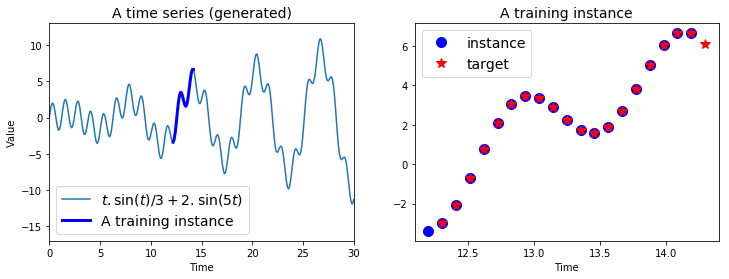

In [88]:
t=np.linspace(t_min, t_max, int((t_max-t_min)/resolution))

n_steps=20
t_instance=np.linspace(12.2, 12.2+resolution*(n_steps+1), n_steps+1)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title('A time series (generated)', fontsize=14)
plt.plot(t, time_series(t), label=r"$t .\sin(t)/3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), 'b-', linewidth=3,
        label='A training instance')
plt.legend(loc='lower left', fontsize=14)
plt.axis([0,30,-17,13])
plt.xlabel('Time')
plt.ylabel('Value')

plt.subplot(122)
plt.title('A training instance', fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), 'bo', markersize=10, label='instance')
plt.plot(t_instance[1:], time_series(t_instance[1:]), 'r*', markersize=10, label='target')
plt.legend(loc='upper left', fontsize=14)
plt.xlabel('Time')

In [89]:
X_batch, y_batch=next_batch(1, n_steps)

In [90]:
np.c_[X_batch[0], y_batch[0]]

array([[ 0.56524711,  0.30812751],
       [ 0.30812751, -0.33272992],
       [-0.33272992, -1.17445601],
       [-1.17445601, -1.98100654],
       [-1.98100654, -2.52115636],
       [-2.52115636, -2.62536421],
       [-2.62536421, -2.22758414],
       [-2.22758414, -1.38178424],
       [-1.38178424, -0.24912546],
       [-0.24912546,  0.94106392],
       [ 0.94106392,  1.9469674 ],
       [ 1.9469674 ,  2.57298539],
       [ 2.57298539,  2.71709827],
       [ 2.71709827,  2.39529672],
       [ 2.39529672,  1.73710381],
       [ 1.73710381,  0.95329129],
       [ 0.95329129,  0.28370056],
       [ 0.28370056, -0.06204979],
       [-0.06204979,  0.04355358],
       [ 0.04355358,  0.61415552]])

<img src='./img/time_series_rnn.png'>
<h4><center>RNN with time series modelling</center></h4>

In [75]:
reset_graph()

n_steps=20
n_inputs=1
n_neurons=100
n_outputs=1
learning_rate=0.001


X=tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y=tf.placeholder(tf.float32, [None, n_steps, n_inputs])

with tf.name_scope('RNN'):
    cell=tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
    rnn_outputs, states=tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
stacked_rnn_outputs=tf.reshape(rnn_outputs, [-1, n_neurons])

with tf.name_scope('flc'):
    stacked_outputs=tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs=tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

with tf.name_scope('training_op'):
    loss=tf.reduce_mean(tf.square(outputs-y))
    optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op=optimizer.minimize(loss)
    
filewriter=tf.summary.FileWriter('./tf_logs/rnn_with_fully_connected_layer', tf.get_default_graph())

In [91]:
init=tf.global_variables_initializer()
saver=tf.train.Saver()

n_iterations=1500
batch_size=50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch=next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        if iteration % 100 ==0:
            mse=loss.eval(feed_dict={X:X_batch, y:y_batch})
            print(iteration, "\tMSE:", mse)
            
    X_new=time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred=sess.run(outputs, feed_dict={X:X_new})
    
    saver.save(sess, './tf_ckpt/my_time_series_model')

0 	MSE: 19.8912
100 	MSE: 0.454091
200 	MSE: 0.24538
300 	MSE: 0.11456
400 	MSE: 0.0846535
500 	MSE: 0.0522733
600 	MSE: 0.0604782
700 	MSE: 0.0504652
800 	MSE: 0.0482148
900 	MSE: 0.0627034
1000 	MSE: 0.0514763
1100 	MSE: 0.0434323
1200 	MSE: 0.051179
1300 	MSE: 0.0507836
1400 	MSE: 0.0400549


In [92]:
y_pred

array([[[-3.45526361],
        [-2.52750373],
        [-1.23513067],
        [ 0.80045998],
        [ 2.24713492],
        [ 3.08726001],
        [ 3.39479327],
        [ 3.3776207 ],
        [ 2.91415   ],
        [ 2.22968554],
        [ 1.69632888],
        [ 1.60580647],
        [ 1.93394208],
        [ 2.76855421],
        [ 3.90190172],
        [ 5.12182999],
        [ 6.13764   ],
        [ 6.70268536],
        [ 6.68567228],
        [ 6.11473274]]], dtype=float32)

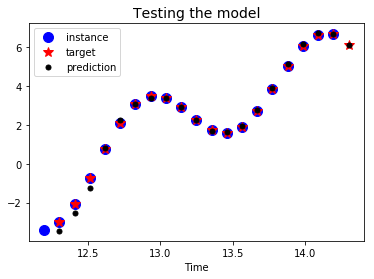

In [95]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "r*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "k.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

# Generating a creative new sequence

- 두개의 sequence를 시작으로 위에서 학습한 rnn을 이용하여 새로운 sequence를 생성한다.

INFO:tensorflow:Restoring parameters from ./tf_ckpt/my_time_series_model


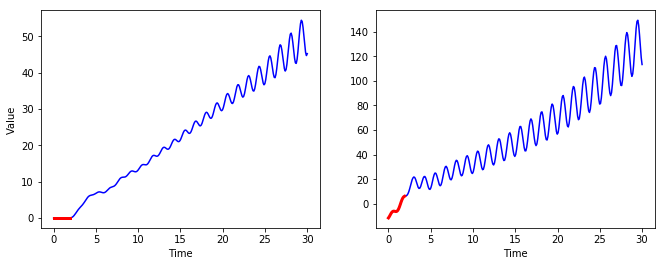

In [97]:
with tf.Session() as sess:
    saver.restore(sess, './tf_ckpt/my_time_series_model')
    
    sequence1=[0. for i in range(n_steps)] ##[0,0,0, ...,0]인 sequence1   
    for iteration in range(len(t)-n_steps):
        X_batch=np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred=sess.run(outputs, feed_dict={X:X_batch})
        sequence1.append(y_pred[0,-1,0])
        ### 가장 마지막 값이 training set에 없는 예측값이므로, 이를 계속 
        ### iteration 마다 append 해준다.
    
    sequence2=[time_series(i*resolution+t_min+(t_max-t_min/3)) for i in range(n_steps)]
    ##위에서 정의한 time_series로 만든 sequence
    
    for iteration in range(len(t)-n_steps):
        X_batch=np.array(sequence2[-n_steps:]).reshape(-1, n_steps, 1)
        y_pred=sess.run(outputs, feed_dict={X:X_batch})
        sequence2.append(y_pred[0,-1,0])


plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "r-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "r-", linewidth=3)
plt.xlabel("Time")
    

# Deep RNN

### MultiRNNCell

![multiRNNcell](./img/multilayer_rnn.png)

- multiRNNCell도 일반적인 RNNCell코드와 비슷하고 딱 한줄만 더 추가하면 된다.

### multi_layer_cell=tf.contrib.rnn.MultiRNNCell(layers)

- 여기서 대신에, layers를 tf.contrib.rnn.BasicRNNCell을 쌓고 싶은 갯수만큼의 cell이 담긴 list이다. 이해가 안된다면 아래의 코드로 확인해 보자.


In [98]:
reset_graph()

n_inputs=2
n_steps=5
n_neurons=100
n_layers=3

X=tf.placeholder(tf.float32, [None, n_steps, n_inputs])
layers=[tf.contrib.rnn.BasicRNNCell(num_units=n_neurons) 
        for layer in range(n_layers)] ### 이부분이 새로 추가
multi_layer_cell=tf.contrib.rnn.MultiRNNCell(layers) ### 이부분이 새로 추가
outputs, states=tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [99]:
states

(<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 100) dtype=float32>,
 <tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 100) dtype=float32>,
 <tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 100) dtype=float32>)

In [101]:
init=tf.global_variables_initializer()
X_batch=np.random.rand(2, n_steps, n_inputs)

with tf.Session() as sess:
    init.run()
    outputs_val, states_val=sess.run([outputs, states], feed_dict={X:X_batch})

In [102]:
outputs_val.shape

(2, 5, 100)

# LSTM

- 이번에는 lstm을 이용해서 위에서 진행한 mnist classification을 해보자.
- rnn과 크게 다르지 않다. cell을 구축할 때, basicRNNCell 에서 basicLSTMCell
  로 바꿔주면 된다.

In [107]:
reset_graph()

lstm_cell=tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)

tf.contrib.rnn.BasicLSTMCell(num_units, forget_bias=1.0, state_is_tuple=True, activation=None, reuse=None)

- num_units : the number of hidden neurons in a cell
- forget_bias : biases of the forget gate in order to reduce the scale of forgetting in the beginning of the training
- state_is_tuple : If True, accepted and returned states are 2-tuples of the 'c_state' and the 'h_state', where 'c' is the hidden state(cell state) and 'h' is the output.

In [108]:
tf.contrib.rnn.BasicLSTMCell?

<img src='./img/sequence_classifier.png'>
<h4><center>sequence_classifier</center></h4>

In [103]:
n_steps=28
n_inputs=28
n_neurons=150
n_outputs=10
n_layers=3
learning_rate=0.001

In [150]:
reset_graph()

X=tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y=tf.placeholder(tf.int32, [None])

lstm_cells=[tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons) for 
            layer in range(n_layers)]
multi_cell=tf.contrib.rnn.MultiRNNCell(lstm_cells)
outputs, states=tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)

top_layer_h_state=states[-1][1]
logits=tf.layers.dense(top_layer_h_state, n_outputs)
xentropy=tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                       logits=logits)
loss=tf.reduce_mean(xentropy, name='loss')
optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op=optimizer.minimize(loss)
correct=tf.nn.in_top_k(logits, y, 1)
accuracy=tf.reduce_mean(tf.cast(correct, tf.float32))

In [151]:
states

(LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_6:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>))

In [152]:
top_layer_h_state

<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>

In [153]:
n_epochs=10
batch_size=150

X_test=mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test=mnist.test.labels

init=tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(int(mnist.train.num_examples//batch_size)):
            X_batch, y_batch=mnist.train.next_batch(batch_size)
            X_batch=X_batch.reshape((batch_size, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        acc_train=accuracy.eval(feed_dict={X:X_batch, y:y_batch})
        acc_test=accuracy.eval(feed_dict={X:X_test, y:y_test})
        print(epoch, 'train accuracy:', acc_train, 'test_accuracy:', acc_test)


0 train accuracy: 0.96 test_accuracy: 0.9532
1 train accuracy: 0.986667 test_accuracy: 0.9717
2 train accuracy: 0.993333 test_accuracy: 0.978
3 train accuracy: 0.98 test_accuracy: 0.9803
4 train accuracy: 0.986667 test_accuracy: 0.9834
5 train accuracy: 0.973333 test_accuracy: 0.9851
6 train accuracy: 0.993333 test_accuracy: 0.9856
7 train accuracy: 1.0 test_accuracy: 0.9858
8 train accuracy: 1.0 test_accuracy: 0.9863
9 train accuracy: 1.0 test_accuracy: 0.9872


# Peephole Connection

- To implement peephole connections, use LSTMCell instead of BasicLSTMCell

In [154]:
### without using peephole connections
lstm_cell=tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)

### with implementing peephole connections
lstm_cell=tf.contrib.rnn.LSTMCell(num_units=n_neurons, use_peepholes=True)

# word embedding 

This section is based on TensorFlow's [Word2Vec tutorial](https://www.tensorflow.org/versions/r0.11/tutorials/word2vec/index.html).

In [157]:
import errno
import os
import zipfile
import urllib.request

## Fetch the data

In [182]:
WORDS_PATH = './datasets/words'
WORDS_URL = 'http://mattmahoney.net/dc/text8.zip'

def mkdir_p(path):
    """Create directories, ok if they already exist"""
        
    if os.path.isdir(path):
        print('%s already exist' %(path))
    else:
        os.makedirs(path)
        print('successfully create directories')
        
def fetch_words_data(words_url=WORDS_URL, words_path=WORDS_PATH):
    mkdir_p(words_path)
    zip_path=os.path.join(words_path, 'words.zip')
    if not os.path.isfile(zip_path):
        urllib.request.urlretrieve(words_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:
        data=f.read(f.namelist()[0])
        return data.decode('ascii').split()
        

In [185]:
words=fetch_words_data()

./datasets/words already exist


In [186]:
words[:5]

['anarchism', 'originated', 'as', 'a', 'term']

In [187]:
len(words)

17005207

## Build the dictionary

step2 : build the dictionary and replace rare words with UNK token

- "UNK" : unknown words

In [193]:
from collections import Counter

vocabulary_size=50000
vocabulary=[('UNK',None)]+Counter(words).most_common(vocabulary_size-1)
vocabulary=np.array([word for word,_ in vocabulary])
# generate dictionary using vocabulary (여기서 code는 위의 vocabulary의 순서를 의미함)
dictionary={word:code for code, word in enumerate(vocabulary)}
data=np.array([dictionary.get(word, 0) for word in words])

In [194]:
data

array([5235, 3083,   12, ...,   22,   16,   73])

In [195]:
dictionary

{'coefficient': 7891,
 'flanagan': 35948,
 'utmost': 20936,
 'brabham': 26461,
 'fusiliers': 45877,
 'disseminated': 22239,
 'cucurbitaceae': 49393,
 'turmeric': 44612,
 'oft': 16633,
 'biochemists': 39749,
 'feist': 33552,
 'reiterated': 25898,
 'hindustani': 23635,
 'domed': 25707,
 'heero': 36448,
 'elmer': 19297,
 'indoctrination': 41482,
 'cabins': 47879,
 'packers': 11866,
 'aromatherapy': 23331,
 'locations': 3078,
 'aldosterone': 41958,
 'flamsteed': 19687,
 'unofficially': 16360,
 'brimstone': 45244,
 'analyzes': 35201,
 'kabbalah': 7691,
 'rink': 19111,
 'declassified': 19958,
 'revere': 21794,
 'misses': 19959,
 'commensurate': 41483,
 'spread': 1346,
 'momentary': 35782,
 'vinyl': 17009,
 'luisa': 32815,
 'bottles': 13303,
 'operational': 4717,
 'csc': 38226,
 'approximating': 28132,
 'monmouth': 16536,
 'randle': 45245,
 'commander': 2089,
 'tropical': 2922,
 'volante': 47136,
 'hubris': 26185,
 'groundbreaking': 16011,
 'colored': 5388,
 'shmuel': 40562,
 'grandeur': 2289

In [197]:
" ".join(words[:9]), data[:9]

('anarchism originated as a term of abuse first used',
 array([5235, 3083,   12,    6,  195,    2, 3136,   46,   59]))

In [198]:
" ".join([vocabulary[word_index] for word_index in [5241, 3081, 12, 6, 195, 2, 3134, 46, 59]])

'sitting matrix as a term of extinct first used'

## Generate batches

function to generate a training batch for the skip_gram model.

In [204]:
print(words[:10])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [201]:
data

array([5235, 3083,   12, ...,   22,   16,   73])

In [214]:
import random
from collections import deque

data_index=0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch=np.ndarray(shape=(batch_size), dtype=np.int32)
    labels=np.ndarray(shape=(batch_size,1), dtype=np.int32)
    span=2*skip_window+1 #[skip_window, target, skip_window]
    buffer=deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index=(data_index+1) % len(data)
    for i in range(batch_size//num_skips):
        target = skip_window # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target=random.randint(0, span-1)
            targets_to_avoid.append(target)
            batch[i*num_skips+j]=buffer[skip_window]
            labels[i*num_skips+j,0]=buffer[target]
        buffer.append(data[data_index])
        data_index=(data_index+1)%len(data)
    return batch, labels

In [215]:
data_index=0
batch, labels=generate_batch(8,2,1)

In [217]:
batch

array([3083, 3083,   12,   12,    6,    6,  195,  195], dtype=int32)

In [216]:
batch, [vocabulary[word] for word in batch]

(array([3083, 3083,   12,   12,    6,    6,  195,  195], dtype=int32),
 ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term'])

In [218]:
labels, [vocabulary[word] for word in labels[:,0]]

(array([[  12],
        [5235],
        [   6],
        [3083],
        [  12],
        [ 195],
        [   2],
        [   6]], dtype=int32),
 ['as', 'anarchism', 'a', 'originated', 'as', 'term', 'of', 'a'])

## Build the model

In [219]:
batch_size=128
embedding_size=150 # Dimension of the embedding vector
skip_window=1 # How many words to consider left and right
num_skips=2 # How many times to reuse an input te generate a label

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

learning_rate = 0.01

In [220]:
reset_graph()

# Input data.
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [221]:
vocabulary_size = 50000
embedding_size = 150

# Look up embeddings for inputs.
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

In [222]:
train_inputs = tf.placeholder(tf.int32, shape=[None])
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [223]:
# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# Add variable initializer.
init = tf.global_variables_initializer()

In [224]:
num_steps = 10001

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in range(num_steps):
        print("\rIteration: {}".format(step), end="\t")
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([training_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocabulary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = vocabulary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

Iteration: 0	Average loss at step  0 :  285.391174316
Nearest to new: tian, dorms, interstates, syst, lemmink, sama, crushed, resigning,
Nearest to people: foreshadowed, bauer, pharaonic, dancers, aeroplane, habitually, ciii, musicology,
Nearest to on: jupiter, overestimated, casas, nicaraguan, residues, monaco, lindy, preserved,
Nearest to or: dispelling, senegalese, wales, spoke, nachrichten, appearance, druidism, smelter,
Nearest to so: justifiably, prokofiev, chickasaw, chewed, engels, staples, rcs, laurens,
Nearest to th: chancellorsville, volkssturm, preeminent, notional, charlize, swabia, thoroughly, crowell,
Nearest to between: accelerates, peacemaker, marcy, osman, chemists, templar, network, constantinople,
Nearest to however: darrow, arian, pita, nonexistent, smelting, signal, comiskey, simplify,
Nearest to i: adp, graphemes, liners, kenjutsu, disambiguation, clav, jannaeus, priests,
Nearest to seven: alison, sacrament, contras, berwick, aymara, sink, frunze, aq,
Nearest to 